Abstract

250 words or less. Identify 4-6 key phrases.

# Background

In most classical statistical theories, random variables are assumed to have Gaussian distributions. How about non-Gaussian cases? Driven by curiosity, we read the paper “Independent component analysis: algorithm and applications”. ICA is a general-purpose statistical technique, with a lot of interesting application in audio processing, biomedical signal processing, image processing, telecommunications, and econometrics. Inspired by cocktail-party problem, ICA attempts to separate mixed signals. Specifically, under the key assumption of non-Gaussianity, ICA gives a linear representation of multivariate data with statistically independent components. 

# Algorithm

## Definition

Assume that we observe $n$ linear variables  $x_1, x_2,…, x_n$. They are mixtures of $m$ independent variables $s_1, s_2,…, s_m$:

$$x_i = a_{i1}s_1+a_{i2}s_2+...+a_{im}s_m$$

The fundamental point is that we observe only the variables $x_i$, whereas both $a_{ij}$ and $s_j$ are to be estimated or inferred. The $s_j$ are the independent components, whereas the coefficients $x_i$ are called the mixing coefficients. Using a vector-matrix notation, the above mixing is written as:

$$x=As.$$

In other words, all we observe is the random vector $x$, and we want to estimate both $A$ and $s$.

## Principles of ICA estimation

### ``Nongaussian is independent''

The Central Limit Theorem tells that the distribution of a sum of independent random variables tends toward a Gaussian distribution, under certain conditions. Thus, a sum of two independent random variables usually has a distribution that is closer to gaussian than any of the two original random variables.

Let’s consider a linear combination of $x_i$: $y=w^Tx = \sum w_i x_i$, where $w$ is a vector to be determined. Denote $z=A^T w$, then we have $y=w^T x=w^T, As= z^T s$. $y$ is thus a linear combination of $s_i$, with weights given by $z_i$. Since a sum of even two independent random variables is more Gaussian than the original variables,  $z^T s$ is more Gaussian than any of the $s_i$ and becomes least Gaussian when it in fact equals one of the $s_i$. In this case, obviously only one of the elements $z_i$ of $z$ is nonzero.

Therefore, we could take as $w$ a vector that maximizes the non-Gaussianity of  $w^T x$. Such a vector would necessarily correspond (in the transformed coordinate system) to a $z$ which has only one nonzero component. This means that $w^T x= z^T s$ equals one of the independent component. Maximizing the non-Gaussianity of  $w^T x$ thus gives us one of the independent components.

### Measures of non-Gaussianity

Here we use approximations of negentropy. Paper “New approximations of differential entropy for independent component analysis and projection pursuit” developed approximations based on the maximum-entropy principle:
$$J(y) \approx \sum_{i=1}^{p} k_i \left[ E \left[G_i (y)\right]-E\left[G_i (v)\right]\right]^2 $$
where $k_i$ are some positive constants, and $v$ is a Gaussian variable of zero mean and unit variance (i.e., standardized). The variable $v$ is assumed to be of zero mean and unit variance, and the functions $G_i$ are some nonquadratic functions. To obtain relatively robust estimators, the following choices of $G$ have proved very useful:
$$G_1 (u) = \frac{1}{a_1}  log⁡cosh⁡\left(a_1 u\right) ,where 1≤a_1≤2$$

$$G_2 (u)=-exp⁡(-u^2/2)$$



## Preprocessing for ICA

Before applying an ICA algorithm, centering and whitening data will make the problem simpler and better conditioned.

## Pseudocode

The general idea is:

    for i=1 to n
        w = random vector;
        orthogonalize initial vector w in terms of the previous components;
        normalize w;
        while (w not converged)
            w = approximation of negentropy of w^T x
            orthogonalize w in terms of the previous components;
            normalize w;
        W(i,:)=w;
    s=W*x

## Python Code

In [ ]:
# %load Source/fastICA_0.py

import numpy as np
from sklearn import preprocessing

def sym_decorrelation(W):
    """ Symmetric decorrelation """
    K = np.dot(W, W.T)
    s, u = np.linalg.eigh(K) 
    W = (u @ np.diag(1.0/np.sqrt(s)) @ u.T) @ W
    return W

def g_logcosh(wx,alpha):
    """derivatives of logcosh"""
    return np.tanh(alpha * wx)
def gprime_logcosh(wx,alpha):
    """second derivatives of logcosh"""
    return alpha * (1-np.square(np.tanh(alpha*wx)))
# exp
def g_exp(wx,alpha):
    """derivatives of exp"""
    return wx * np.exp(-np.square(wx)/2)
def gprime_exp(wx,alpha):
    """second derivatives of exp"""
    return (1-np.square(wx)) * np.exp(-np.square(wx)/2)

def fastICA_0(X, f,alpha=None, n_comp=None,maxit=200, tol=1e-04):
    """FastICA algorithm for several units"""
    n,p = X.shape
    #check if n_comp is valid
    if n_comp is None:
        n_comp = min(n,p)
    elif n_comp > min(n,p):
        print("n_comp is too large")
        n_comp = min(n,p)
        
    #centering
    #by subtracting the mean of each column of X (array).
    X = preprocessing.scale(X,axis = 0,with_std=False)
    X = X.T

    #whitening
    svd = np.linalg.svd(X @ (X.T) / n)
    k = np.diag(1/np.sqrt(svd[1])) @ (svd[0].T)
    k = k[:n_comp,:] 
    X1 = k @ X

    # initial random weght vector
    w_init = np.random.normal(size=(n_comp, n_comp))
    W = sym_decorrelation(w_init)
    lim = 1
    it = 0
    
    
    # The FastICA algorithm
    if f == "logcosh":
        while lim > tol and it < maxit :
            wx = W @ X1
            gwx = g_logcosh(wx,alpha)
            g_wx = gprime_logcosh(wx,alpha)
            W1 = np.dot(gwx,X1.T)/X1.shape[1] - np.dot(np.diag(g_wx.mean(axis=1)),W)
            W1 = sym_decorrelation(W1)
            it = it +1
            lim = np.max(np.abs(np.abs(np.diag(W1 @ W.T)) - 1.0))
            W = W1

        S = W @ X1
        A = np.linalg.inv(W @ k)
        X_re = A @ S
        return{'X':X1.T,'X_re':X_re.T,'A':A.T,'S':S.T}

    elif f == "exp":
        while lim > tol and it < maxit :
            wx = W @ X1
            gwx = g_exp(wx,alpha)
            g_wx = gprime_exp(wx,alpha)
            W1 = np.dot(gwx,X1.T)/X1.shape[1] - np.dot(np.diag(g_wx.mean(axis=1)),W)
            W1 = sym_decorrelation(W1)
            it = it +1
            lim = np.max(np.abs(np.abs(np.diag(W1 @ W.T)) - 1.0))
            W = W1

        S = W @ X1
        A = np.linalg.inv(W @ k)
        X_re = A @ S
        return{'X':X1.T,'X_re':X_re.T,'A':A.T,'S':S.T}

    else:
        print("doesn't support this approximation negentropy function")

# Code Profiling and Optimization

## line_profiler

In [3]:
!python -m line_profiler fastICA_00.py.lprof

Timer unit: 1e-06 s

Total time: 4.34743 s
File: Test/fastICA_00.py
Function: fastICA_00 at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                           @profile
    32                                           def fastICA_00(X, f,alpha=None, n_comp=None,maxit=200, tol=1e-04):
    33                                               """FastICA algorithm for several units"""
    34         1           10     10.0      0.0      n,p = X.shape
    35                                               #check if n_comp is valid
    36         1            2      2.0      0.0      if n_comp is None:
    37                                                   n_comp = min(n,p)
    38         1            3      3.0      0.0      elif n_comp > min(n,p):
    39                                                   print("n_comp is too large")
    40                                                   n_comp = min(n,p)
    41                              

## Bottlenecks
We used line profiler to identify the bottlenecks.
From the result, it can be observed that the biggest bottleneck in the fastica function are "np.tanh" ("g_logcosh" and "gprime_logcosh") and 'np.linalg.svd' function, which take about 90% percent of the time when running fastica function. The next bottleneck are 'preprocessing.scale'and matrix dot product.

## Parallelism

## Optimization for Performance

We show the improved efficiency below for all major update functions.

In [6]:
%run Test/fMRI.py
%run Source/fastICA_0.py
%run Source/fastICA_1.py
%run Source/fastICA_3.py
%run Source/fastICA_scipy.py
%run Source/fastICA_jit.py
%run Source/fastICA_ne.py

In [7]:
%timeit -r2 -n4 fastICA_0(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 4.43 s per loop


In [10]:
%timeit -r2 -n4 fastICA_1(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 4.71 s per loop


In [12]:
%timeit -r2 -n4 fastICA_scipy(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 4.62 s per loop


In [15]:
%timeit -r2 -n4 fastICA_3(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 84 ms per loop


In [13]:
%timeit -r2 -n4 fastICA_jit(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 109 ms per loop


In [14]:
%timeit -r2 -n4 fastICA_ne(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 66.5 ms per loop


# Application

## Simulated Test Data

In [20]:
%run Test/test.py

### True Source Components

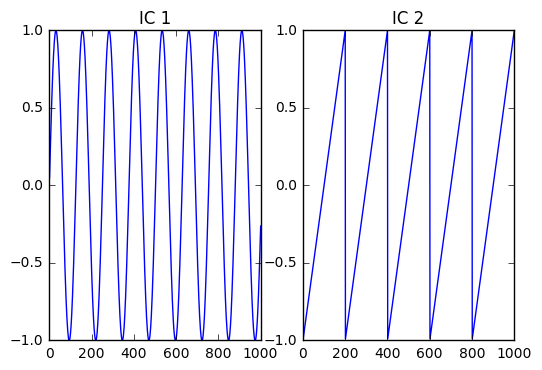

In [23]:
test(S_test)

### ICs by FastICA

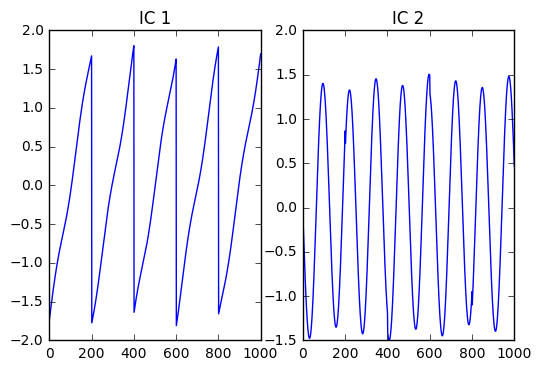

In [24]:
test(fastICA_ne(X_test,f = "logcosh",n_comp =2, alpha = 1,maxit = 200, tol = 0.0001)['S'])

## Real World Data

This is a subsample of real fMRI data from the 1000 Connectome Project.

In [25]:
fMRI.shape

(30000, 20)

Before applying the fastICA, a visualization of the original data

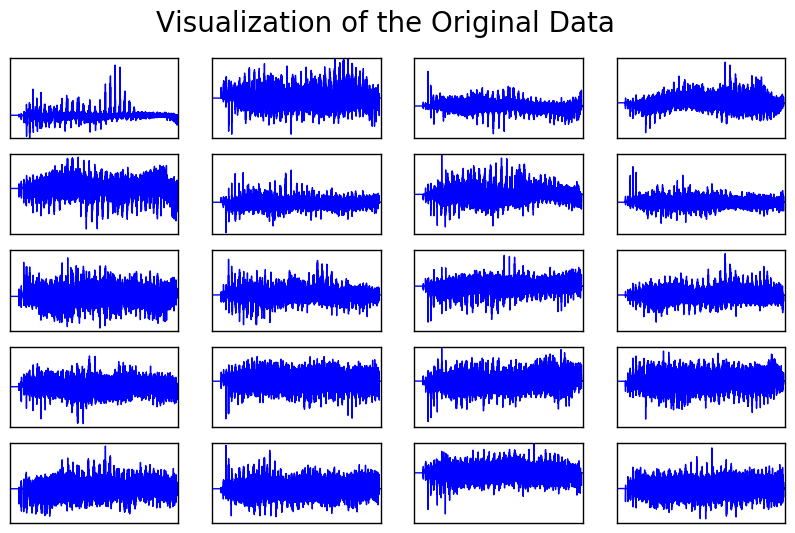

In [26]:
fig = plt.figure(figsize=(10,6)) 
for i in range(20):
    ax = plt.subplot(5,4,i+1)
    plt.plot(np.arange(30000)+1, fMRI[:,i])
    plt.xticks([])
    plt.yticks([])
fig.suptitle('Visualization of the Original Data', fontsize=20)
pass

After appplying FastICA algorithm, we visualize each independent component in the following plot

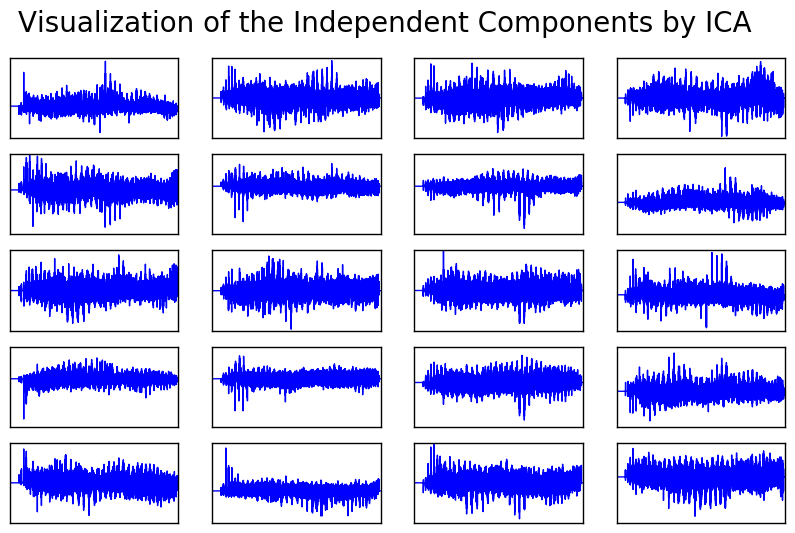

In [27]:
ica_fMRI = fastICA_ne(fMRI,f = "logcosh", alpha = 1,maxit = 200, tol = 0.0001)
S_fMRI = ica_fMRI['S']
fig = plt.figure(figsize=(10,6)) 
for i in range(20):
    ax = plt.subplot(5,4,i+1)
    plt.plot(np.arange(30000)+1, S_fMRI[:,i])
    plt.xticks([])
    plt.yticks([])
fig.suptitle('Visualization of the Independent Components by ICA', fontsize=20)
pass